In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap

In [70]:
# Load the uploaded data file to examine its contents and structure.
file_path = 'combined_expression_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows and basic info to understand the dataset structure.
data_info = data.info()
data_head = data.head(50)
data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 29644 entries, Patient_id to bP-2189O9.3
dtypes: float64(27664), int64(1971), object(9)
memory usage: 4.5+ MB


(None,
    Patient_id    Sample Tissue_origin    Histology     Sex  Age Smoking  \
 0       P0018  LUNG_N18         nLung          ADC  Female   62      Ex   
 1       P0030  LUNG_N30         nLung          ADC    Male   56   Never   
 2       P0009  LUNG_T09         tLung          ADC    Male   67      Ex   
 3       P0034  LUNG_T34         tLung          ADC    Male   64   Never   
 4       P0018  LUNG_T18         tLung          ADC    Male   62      Ex   
 5       P0031  LUNG_N31         nLung          ADC    Male   65      Ex   
 6       P0020  LUNG_N20         nLung          ADC    Male   55     Cur   
 7       P0008  LUNG_N08         nLung          ADC    Male   60   Never   
 8       P0031  LUNG_T31         tLung          ADC    Male   65      Ex   
 9       P0006  LUNG_N06         nLung          ADC    Male   54      Ex   
 10      P0034  LUNG_N34         nLung          ADC    Male   64   Never   
 11      P0028  LUNG_T28         tLung  ADC(Double)    Male   73     Cur   
 12  

In [71]:
def create_pca_plot(data, feature_name, binary_colors=('green', 'red'), 
                   figsize=(10, 8), alpha=0.7, random_state=42):
    """
    Create PCA plot colored by specified metadata feature
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing both gene expression data and metadata
    feature_name : str
        Name of the metadata feature to use for coloring (e.g., 'Tissue_origin', 'Sex', etc.)
    binary_colors : tuple
        Colors to use for binary features (default: ('green', 'red'))
    figsize : tuple
        Size of the figure (default: (10, 8))
    alpha : float
        Transparency of points (default: 0.7)
    random_state : int
        Random state for PCA (default: 42)
    
    Returns:
    --------
    fig : matplotlib figure
        The generated figure
    pca_result : numpy.ndarray
        The PCA transformed data
    explained_variance : numpy.ndarray
        The explained variance ratios
    """
    # Extract feature values
    feature_values = data[feature_name]
    unique_values = feature_values.unique()
    
    # Extract numeric data for PCA
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    
    # Remove any metadata columns that might have numeric dtype
    metadata_cols = ['Patient_id', 'Sample', 'Age', 'Stage']
    numeric_cols = [col for col in numeric_data.columns 
                   if col not in metadata_cols]
    
    # Prepare expression data
    expression_data = numeric_data[numeric_cols].values
    
    # Standardize the data
    scaler = StandardScaler()
    expression_data_scaled = scaler.fit_transform(expression_data)
    
    # Perform PCA
    pca = PCA(n_components=2, random_state=random_state)
    pca_result = pca.fit_transform(expression_data_scaled)
    
    # Create color mapping
    if len(unique_values) == 2:
        # Binary feature - use specified colors
        color_dict = dict(zip(unique_values, binary_colors))
        colors = feature_values.map(color_dict)
    else:
        # Multiple categories - use seaborn color palette
        palette = sns.color_palette("husl", n_colors=len(unique_values))
        color_dict = dict(zip(unique_values, palette))
        colors = feature_values.map(color_dict)
    
    # Create the plot
    fig = plt.figure(figsize=figsize)
    
    # Scatter plot
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, alpha=alpha)
    
    # Add labels and title
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance explained)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance explained)")
    plt.title(f"PCA of Gene Expression Profiles\nColored by {feature_name}")
    
    # Create legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 label=f'{val}',
                                 markerfacecolor=color_dict[val], 
                                 markersize=8)
                      for val in unique_values]
    plt.legend(handles=legend_elements, title=feature_name)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.3)
    
    return fig, pca_result, pca.explained_variance_ratio_

# Example usage:
def plot_multiple_features(data, feature_list):
    """
    Create PCA plots for multiple features
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing both gene expression data and metadata
    feature_list : list
        List of features to create PCA plots for
    """
    for feature in feature_list:
        fig, pca_result, exp_var = create_pca_plot(data, feature)
        plt.show()
        print(f"\nFeature: {feature}")
        print(f"Total variance explained: {sum(exp_var):.1%}")
        print(f"PC1 variance: {exp_var[0]:.1%}")
        print(f"PC2 variance: {exp_var[1]:.1%}")
        print("-" * 50)


def analyze_single_gene_log2(data, gene_name):
    """
    Analyze expression of a single gene between normal and tumor lung samples
    """
    # Separate normal and tumor samples
    normal_expr = data[data['Tissue_origin'] == 'nLung'][gene_name]
    tumor_expr = data[data['Tissue_origin'] == 'tLung'][gene_name]
    
    # Statistical tests
    # Welch's t-test
    t_stat, t_pval = stats.ttest_ind(normal_expr, tumor_expr, 
                                    equal_var=False, nan_policy='omit')
    
    # Calculate means and fold change
    normal_mean = normal_expr.mean()
    tumor_mean = tumor_expr.mean()
    fold_change = tumor_mean - normal_mean  # Direct subtraction since data is log2
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt((normal_expr.var() + tumor_expr.var()) / 2)
    cohens_d = (tumor_mean - normal_mean) / pooled_std if pooled_std != 0 else np.nan
    
    # Create results dictionary
    results = {
        'Gene': gene_name,
        'Normal_Mean': normal_mean,
        'Tumor_Mean': tumor_mean,
        'Fold_Change': fold_change,
        'T_statistic': t_stat,
        'T_test_pvalue': t_pval,
        'Cohens_d': cohens_d,
        'Normal_Samples': len(normal_expr),
        'Tumor_Samples': len(tumor_expr)
    }
    
    return results

def batch_analyze_genes_log2(data, p_threshold=0.05, fc_threshold=1.0):
    """
    Analyze multiple genes and return compiled results
    """
    # Get numeric columns (potential genes)
    gene_list = data.select_dtypes(include=['float64', 'int64']).columns
    
    results_list = []
    for gene in gene_list:
        try:
            results = analyze_single_gene_log2(data, gene)
            results_list.append(results)
        except:
            continue
    
    # Compile results into DataFrame
    results_df = pd.DataFrame(results_list)
    
    # Add significance indicators
    results_df['Significant'] = (results_df['T_test_pvalue'] < p_threshold) & \
                               (abs(results_df['Fold_Change']) > fc_threshold)
    
    # Sort by p-value and fold change
    results_df['Abs_Fold_Change'] = abs(results_df['Fold_Change'])
    results_df.sort_values(['T_test_pvalue', 'Abs_Fold_Change'], 
                          ascending=[True, False], inplace=True)
    
    return results_df

def get_differential_genes(data, p_threshold=0.05, fc_threshold=1.0):
    """
    Identify differential genes and create filtered dataframe
    """
    # Run batch analysis
    results = batch_analyze_genes_log2(data, p_threshold=p_threshold, fc_threshold=fc_threshold)
    
    # Filter for significant genes
    significant_genes = results[results['Significant']]['Gene'].tolist()
    
    # Create filtered dataframe with only significant genes
    # Keep metadata columns and significant genes
    metadata_cols = ['Patient_id', 'Sample', 'Tissue_origin', 'Histology', 
                    'Sex', 'Age', 'Smoking', 'Pathology', 'EGFR', 'Stage']
    filtered_data = data[metadata_cols + significant_genes]
    
    # Standardize the gene expression values
    scaler = StandardScaler()
    gene_data = filtered_data[significant_genes]
    scaled_gene_data = pd.DataFrame(
        scaler.fit_transform(gene_data),
        columns=gene_data.columns,
        index=gene_data.index
    )
    
    # Combine metadata with scaled gene expression
    filtered_data[significant_genes] = scaled_gene_data
    
    return filtered_data, results

# Run the analysis
filtered_df, analysis_results = get_differential_genes(data, p_threshold=0.1, fc_threshold=1.0)

# Print summary
print("\nAnalysis Results:")
print(f"Number of samples: {len(filtered_df)}")
print(f"Number of differential genes: {len(filtered_df.columns) - 10}")  # subtract metadata columns

print("\nTop 10 most significant genes:")
print(analysis_results[['Gene', 'Fold_Change', 'T_test_pvalue', 'Cohens_d']]
      .head(10).to_string(index=False))

# Save filtered dataset
#filtered_df.to_csv('differential_genes_expression.csv', index=False)

# Display shape of filtered dataset
print("\nFiltered dataset shape:", filtered_df.shape)


Analysis Results:
Number of samples: 20
Number of differential genes: 53

Top 10 most significant genes:
         Gene  Fold_Change  T_test_pvalue  Cohens_d
RP11-459I19.1    -0.016083   4.904222e-07 -3.518171
      TSPAN32    -0.096645   8.393031e-07 -3.468839
       MCEMP1    -1.805053   1.702555e-06 -3.170602
         SUN2    -0.216959   2.388081e-06 -3.082371
        FABP4    -2.568219   2.405133e-06 -3.097629
          FGR    -0.447066   2.658931e-06 -3.037646
  AC009133.17     0.000815   4.343618e-06  2.896443
        GFOD1    -0.051367   4.905616e-06 -2.889210
   FAM13A-AS1    -0.007549   5.622745e-06 -3.199132
        CORO6    -0.006945   5.885034e-06 -3.141915

Filtered dataset shape: (20, 63)


/var/folders/dh/ct60f64n7r30w2htbyy2py5c0000gn/T/ipykernel_1304/58049854.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[significant_genes] = scaled_gene_data


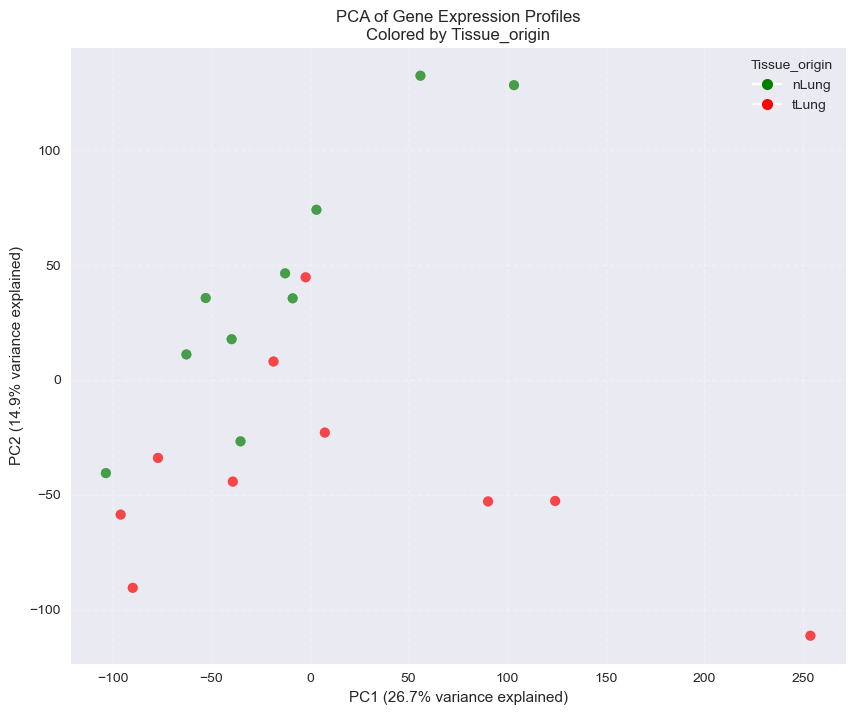


Feature: Tissue_origin
Total variance explained: 41.6%
PC1 variance: 26.7%
PC2 variance: 14.9%
--------------------------------------------------


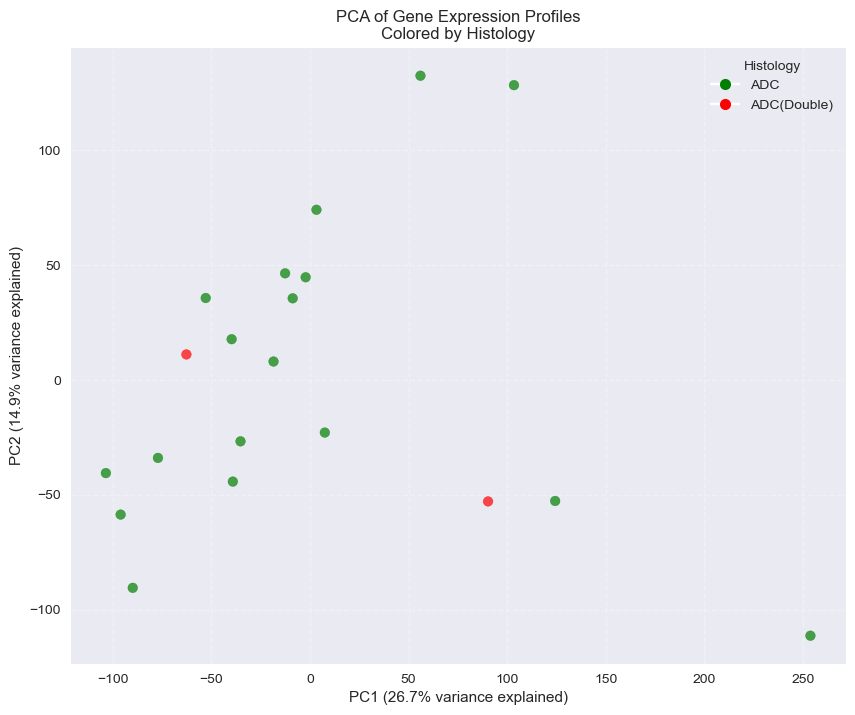


Feature: Histology
Total variance explained: 41.6%
PC1 variance: 26.7%
PC2 variance: 14.9%
--------------------------------------------------


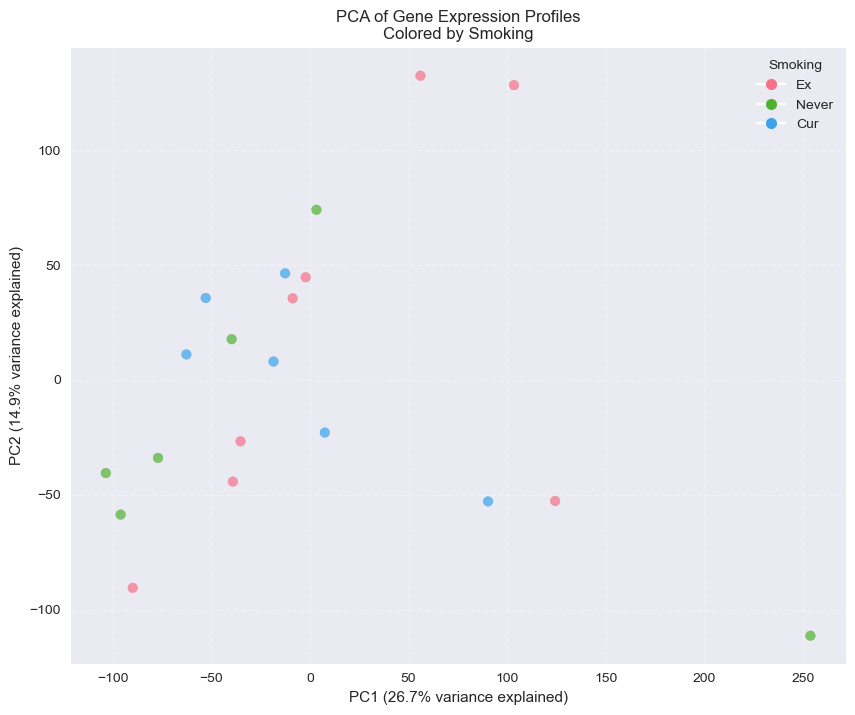


Feature: Smoking
Total variance explained: 41.6%
PC1 variance: 26.7%
PC2 variance: 14.9%
--------------------------------------------------


In [81]:



# Example use:
features_to_plot = ['Tissue_origin', 'Histology', 'Smoking']
plot_multiple_features(data, features_to_plot)

In [73]:


def analyze_single_gene(data, gene_name, feature, group1=None, group2=None):
    """
    Analyze expression of a single gene between two groups based on any metadata feature
    """
    # Get unique groups if not specified
    if group1 is None or group2 is None:
        unique_groups = data[feature].unique()
        group1 = unique_groups[0]
        group2 = unique_groups[1]
    
    # Separate groups
    group1_expr = data[data[feature] == group1][gene_name]
    group2_expr = data[data[feature] == group2][gene_name]
    
    # Statistical tests
    t_stat, t_pval = stats.ttest_ind(group1_expr, group2_expr, 
                                    equal_var=False, nan_policy='omit')
    
    # Calculate means and fold change
    group1_mean = group1_expr.mean()
    group2_mean = group2_expr.mean()
    fold_change = group2_mean - group1_mean  # Direct subtraction since data is log2
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt((group1_expr.var() + group2_expr.var()) / 2)
    cohens_d = (group2_mean - group1_mean) / pooled_std if pooled_std != 0 else np.nan
    
    # Create results dictionary
    results = {
        'Gene': gene_name,
        'Feature': feature,
        'Group1': group1,
        'Group2': group2,
        f'{group1}_Mean': group1_mean,
        f'{group2}_Mean': group2_mean,
        'Fold_Change': fold_change,
        'T_statistic': t_stat,
        'T_test_pvalue': t_pval,
        'Cohens_d': cohens_d,
        f'{group1}_Samples': len(group1_expr),
        f'{group2}_Samples': len(group2_expr)
    }
    
    return results

def batch_analyze_genes(data, feature, group1=None, group2=None):
    """
    Analyze multiple genes for a specific metadata feature
    """
    # Get numeric columns (potential genes)
    gene_list = data.select_dtypes(include=['float64', 'int64']).columns
    
    # Remove any metadata columns that might have numeric dtype
    metadata_cols = ['Patient_id', 'Sample', 'Age', 'Stage']
    gene_list = [col for col in gene_list if col not in metadata_cols]
    
    results_list = []
    for gene in gene_list:
        try:
            results = analyze_single_gene(data, gene, feature, group1, group2)
            results_list.append(results)
        except:
            continue
    
    # Compile results into DataFrame
    results_df = pd.DataFrame(results_list)
    
    # Add absolute fold change
    results_df['Abs_Fold_Change'] = abs(results_df['Fold_Change'])
    
    return results_df

def get_differential_genes_multi(data, features, p_threshold=0.05, fc_threshold=1.0, 
                               top_n=None, ranking_method='combined'):
    """
    Identify differential genes with flexible output format
    
    If 'Smoking' is selected as the feature, convert 'Ex' and 'Current' smokers into 'Smoker'
    and compare 'Smoker' vs. 'Never'.
    """
    # Convert single feature to list for processing
    if isinstance(features, str):
        features = [features]
        return_single = True
    else:
        return_single = False
    
    filtered_dfs = {}
    all_results = {}
    
    # Modify data if Smoking feature is selected
    modified_data = data.copy()
    if 'Smoking' in features:
        # Merge 'Ex' and 'Current' into 'Smoker'
        modified_data['Smoking'] = modified_data['Smoking'].replace({'Ex': 'Smoker', 'Cur': 'Smoker'})
        # Keep only 'Smoker' and 'Never'
        modified_data = modified_data[modified_data['Smoking'].isin(['Smoker', 'Never'])]

    for feature in features:
        if feature == 'Smoking':
            # Compare 'Smoker' vs 'Never'
            results = batch_analyze_genes(modified_data, feature, group1='Never', group2='Smoker')
        else:
            results = batch_analyze_genes(modified_data, feature)
        
        # Add significance indicators
        results['Significant'] = (results['T_test_pvalue'] < p_threshold) & \
                                 (results['Abs_Fold_Change'] > fc_threshold)
        
        # Rank genes
        if ranking_method == 'pvalue':
            results['Rank_Score'] = -np.log10(results['T_test_pvalue'])
        elif ranking_method == 'fold_change':
            results['Rank_Score'] = results['Abs_Fold_Change']
        else:  # combined
            results['Rank_Score'] = -np.log10(results['T_test_pvalue']) * results['Abs_Fold_Change']
        
        # Sort by ranking score
        results = results.sort_values('Rank_Score', ascending=False)
        
        # Select genes based on criteria
        if top_n is not None:
            significant_genes = results['Gene'].head(top_n).tolist()
        else:
            significant_genes = results[results['Significant']]['Gene'].tolist()
        
        # Create filtered dataframe with selected genes
        metadata_cols = ['Patient_id', 'Sample', 'Tissue_origin', 'Histology', 
                         'Sex', 'Age', 'Smoking', 'Pathology', 'EGFR', 'Stage']
        filtered_data = modified_data[metadata_cols + significant_genes]
        
        # Standardize the gene expression values
        scaler = StandardScaler()
        gene_data = filtered_data[significant_genes]
        scaled_gene_data = pd.DataFrame(
            scaler.fit_transform(gene_data),
            columns=gene_data.columns,
            index=gene_data.index
        )
        
        # Combine metadata with scaled gene expression
        filtered_data[significant_genes] = scaled_gene_data
        
        # Store results
        filtered_dfs[feature] = filtered_data
        all_results[feature] = results
        
        # Print summary for this feature
        print(f"\nAnalysis Results for {feature}:")
        print(f"Number of samples: {len(filtered_data)}")
        print(f"Number of selected genes: {len(significant_genes)}")
        print("\nTop 5 genes:")
        print(results[['Gene', 'Group1', 'Group2', 'Fold_Change', 
                       'T_test_pvalue', 'Rank_Score']].head().to_string(index=False))
        print("-" * 50)
    
    # Return single DataFrame if only one feature, dictionary otherwise
    if return_single:
        return filtered_dfs[features[0]], all_results[features[0]]
    else:
        return filtered_dfs, all_results

# Example usage:
#For top N genes:
filtered_cancer, cancer_results = get_differential_genes_multi(
    data, 
    'Tissue_origin',
    top_n=100,
    ranking_method='combined'  # or 'pvalue' or 'fold_change'
)

# For threshold-based selection:
# filtered_dfs, results = get_differential_genes_multi(
#     data, 
#     ['Tissue_origin', 'Smoking'],
#     p_threshold=0.05,
#     fc_threshold=1.0
# )

# Example usage
# For a single feature:
#filtered_df, results = get_differential_genes_multi(data, 'Tissue_origin')

# For multiple features:
#features_to_analyze = ['Tissue_origin', 'Smoking']
#filtered_dfs, all_results = get_differential_genes_multi(data, features_to_analyze)


Analysis Results for Tissue_origin:
Number of samples: 20
Number of selected genes: 100

Top 5 genes:
   Gene Group1 Group2  Fold_Change  T_test_pvalue  Rank_Score
  FABP4  nLung  tLung    -2.568219       0.000002   14.430467
 MCEMP1  nLung  tLung    -1.805053       0.000002   10.413166
  IGLC2  nLung  tLung     3.336348       0.001235    9.703735
SCGB1A1  nLung  tLung    -2.533597       0.000468    8.437212
   IGKC  nLung  tLung     3.200134       0.002985    8.080609
--------------------------------------------------


/var/folders/dh/ct60f64n7r30w2htbyy2py5c0000gn/T/ipykernel_1304/185516433.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[significant_genes] = scaled_gene_data


In [74]:
filtered_cancer

,Patient_id,Sample,Tissue_origin,Histology,Sex,Age,Smoking,Pathology,EGFR,Stage,...,PDLIM1,LTB,TPSB2,GSTO1,IGHA2,SSR4,PFN1,HLA-DRA,GPD1,WFDC2
0,P0018,LUNG_N18,nLung,ADC,Female,62,Ex,MD,del19,IA,...,0.799534,-0.271952,-0.971772,0.990071,-0.767322,-0.399729,1.039785,1.089365,0.437080,-0.295782
1,P0030,LUNG_N30,nLung,ADC,Male,56,Never,na,del19,IA,...,-0.737172,-0.951794,-1.522422,-1.136166,-0.805459,-1.669109,-0.649204,-0.596117,-0.210339,-0.643940
2,P0009,LUNG_T09,tLung,ADC,Male,67,Ex,PD,WT,IIA,...,-1.530561,0.952751,-0.141151,0.480567,1.726313,0.388708,0.267309,0.760441,-1.020988,-0.475782
3,P0034,LUNG_T34,tLung,ADC,Male,64,Never,MD,WT,IA3,...,0.100721,-0.900192,-0.369453,-0.958952,-0.707096,1.443965,-1.822416,-1.774006,-0.886301,2.662765
4,P0018,LUNG_T18,tLung,ADC,Male,62,Ex,MD,del19,IA,...,-0.239765,0.557804,0.295946,-0.278158,-0.238937,1.524578,-0.421745,-0.818355,-1.053321,2.497901
5,P0031,LUNG_N31,nLung,ADC,Male,65,Ex,na,WT,IIIA,...,0.380753,-1.125962,-1.256860,-0.408470,-0.599402,-1.073139,0.014252,-0.325107,-0.234106,-0.548620
6,P0020,LUNG_N20,nLung,ADC,Male,55,Cur,PD,WT,IA,...,0.097606,-0.885563,-1.115825,0.916633,-0.818143,-0.751051,-0.211900,0.489483,1.048079,-0.523280
7,P0008,LUNG_N08,nLung,ADC,Male,60,Never,MD,L858R,IB,...,1.360740,-0.472690,-0.117859,1.051782,-0.033093,-0.663359,1.235936,0.803102,0.970408,-0.206254
8,P0031,LUNG_T31,tLung,ADC,Male,65,Ex,na,WT,IIIA,...,-1.151171,-0.006035,0.594813,-1.563066,0.418049,0.818758,-1.533580,-1.995072,-0.952100,-0.251466
9,P0006,LUNG_N06,nLung,ADC,Male,54,Ex,MD,na,IA,...,2.420739,-0.808597,-0.923015,1.893940,-0.821136,-0.296599,1.795920,1.661988,1.605097,-0.705521


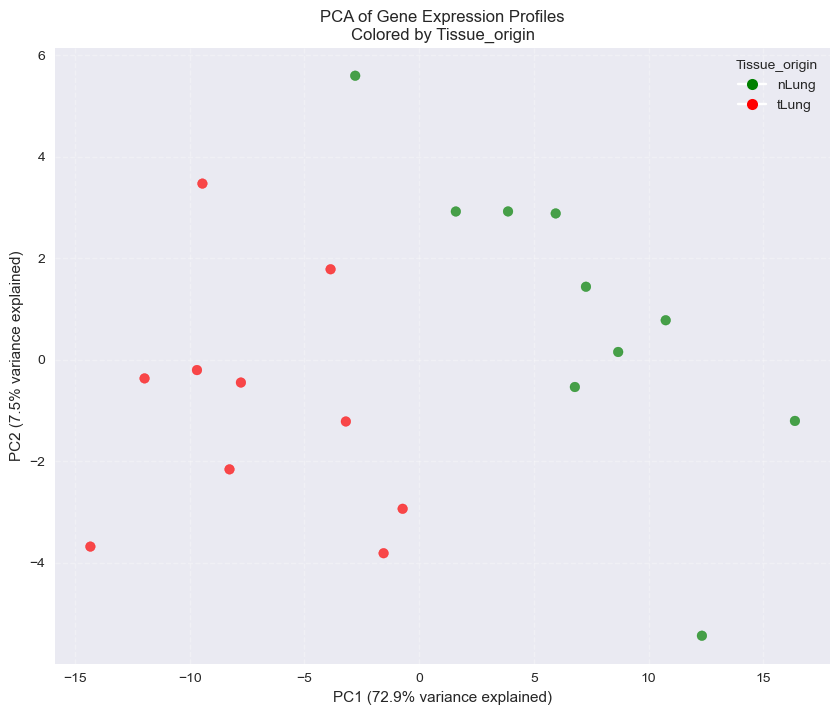


Feature: Tissue_origin
Total variance explained: 80.4%
PC1 variance: 72.9%
PC2 variance: 7.5%
--------------------------------------------------


In [75]:
plot_multiple_features(filtered_cancer, ['Tissue_origin'])

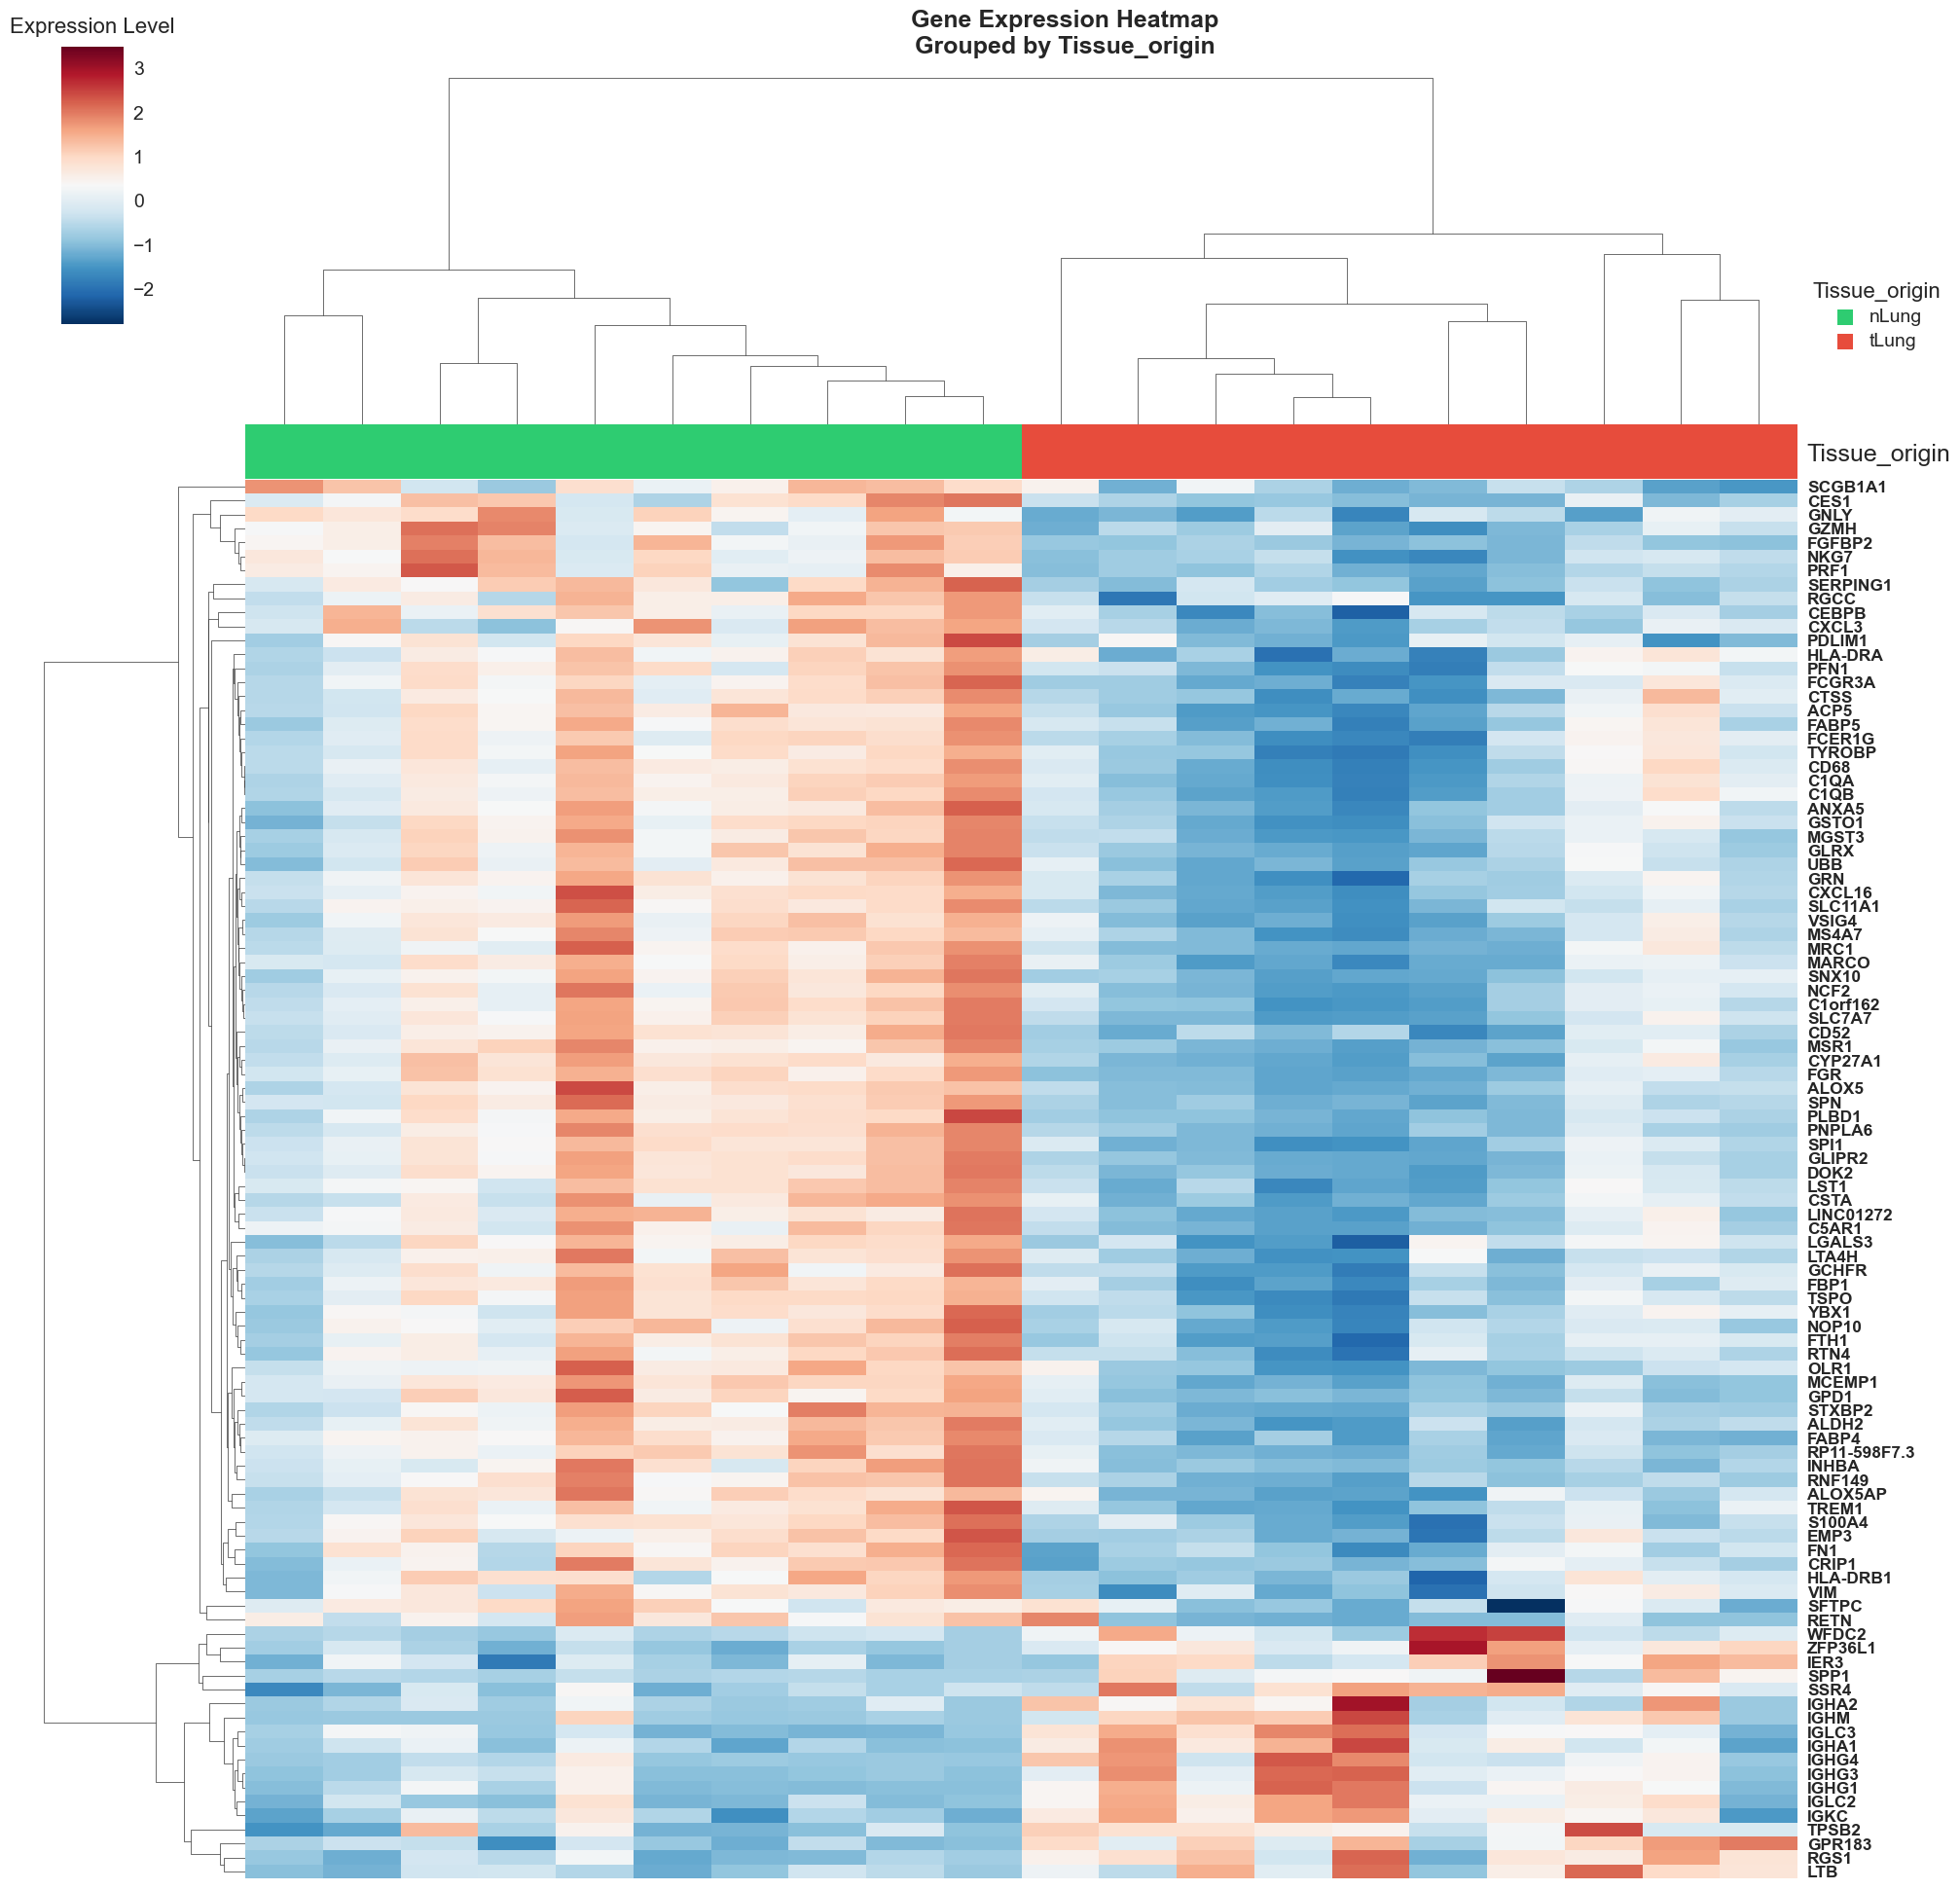

In [76]:

def gene_expression_heatmap(data, feature, top_n=50, figsize=(21.5, 19)):
    plt.style.use('seaborn')
    
    # Create a copy of the data and modify Smoking status
    data = data.copy()
    if feature == 'Smoking':
        data['Smoking'] = data['Smoking'].map({
            'Never': 'Control',
            'Ex': 'Smoker',
            'Cur': 'Smoker',
            'Current': 'Smoker',
            'Smoker': 'Smoker'
        })
    
    # Get feature values
    feature_values = data[feature]
    
    # Create color dictionary based on the feature
    if feature == 'Smoking':
        color_dict = {'Control': '#2ecc71', 'Smoker': '#e74c3c'}
    else:
        color_dict = {'nLung': '#2ecc71', 'tLung': '#e74c3c'}
    
    # Select genes (exclude metadata columns)
    metadata_cols = ['Patient_id', 'Sample', 'Tissue_origin', 'Histology', 
                    'Sex', 'Age', 'Smoking', 'Pathology', 'EGFR', 'Stage']
    gene_cols = [col for col in data.columns if col not in metadata_cols]
    
    if top_n and top_n < len(gene_cols):
        gene_cols = gene_cols[:top_n]
    
    expression_data = data[gene_cols].T
    col_colors = pd.Series(feature_values).map(color_dict)
    
    colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7',
             '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
    cmap = LinearSegmentedColormap.from_list('custom_diverging', colors)
    
    # Create clustergrid
    g = sns.clustermap(expression_data,
                      figsize=figsize,
                      cmap=cmap,
                      col_colors=col_colors,
                      row_cluster=True,
                      col_cluster=True,
                      yticklabels=True,
                      xticklabels=False,
                      dendrogram_ratio=(0.12, 0.2),
                      metric='correlation',
                      method='average')
    
    # Remove the existing colorbar
    g.cax.remove()
    
    # Create a new axis for the colorbar
    cbar_ax = g.fig.add_axes([0.02, 0.85, 0.03, 0.15])
    
    # Create a new colorbar
    norm = plt.Normalize(vmin=expression_data.min().min(), 
                        vmax=expression_data.max().max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, cax=cbar_ax)
    
    # Adjust colorbar appearance
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('Expression Level', 
                      size=16, 
                      pad=10)
    
    plt.setp(g.ax_heatmap.get_yticklabels(), 
             rotation=0,
             fontsize=12.5,
             fontweight='bold')
    
    # Add feature legend
    legend_elements = [plt.Line2D([0], [0], marker='s', color='w', 
                                 markerfacecolor=color_dict[key], 
                                 markersize=12,
                                 label=key)
                      for key in color_dict.keys()]
    
    # Remove tight_layout and add specific positioning
    plt.subplots_adjust(right=0.85)
    
    legend = g.ax_heatmap.legend(handles=legend_elements,
                                title=feature,
                                loc='upper right',
                                bbox_to_anchor=(1.1, 1.15))
    
    plt.setp(legend.get_title(), fontsize=16)
    plt.setp(legend.get_texts(), fontsize=14)
    
    # Add title
    g.fig.suptitle(f'Gene Expression Heatmap\nGrouped by {feature}',
                   fontsize=18, 
                   y=1.02, 
                   fontweight='bold')
    
    # Target the feature label in the third axis
    plt.setp(g.figure.axes[2].get_yticklabels(), fontsize=18)
    
    return g

# Example usage:
g = gene_expression_heatmap(filtered_cancer, 'Tissue_origin', top_n=100)
plt.savefig('heatmap.png', dpi=600, bbox_inches='tight', pad_inches=0.5)
plt.show()

/var/folders/dh/ct60f64n7r30w2htbyy2py5c0000gn/T/ipykernel_1304/185516433.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[significant_genes] = scaled_gene_data



Analysis Results for Smoking:
Number of samples: 20
Number of selected genes: 100

Top 5 genes:
   Gene Group1 Group2  Fold_Change  T_test_pvalue  Rank_Score
   APOE  Never Smoker     1.562064       0.000525    5.123707
SCGB3A1  Never Smoker    -1.848811       0.009519    3.737188
  CCL18  Never Smoker     1.295725       0.030868    1.957187
SCGB3A2  Never Smoker    -1.484853       0.051933    1.907375
   CTSB  Never Smoker     0.849592       0.009267    1.727287
--------------------------------------------------


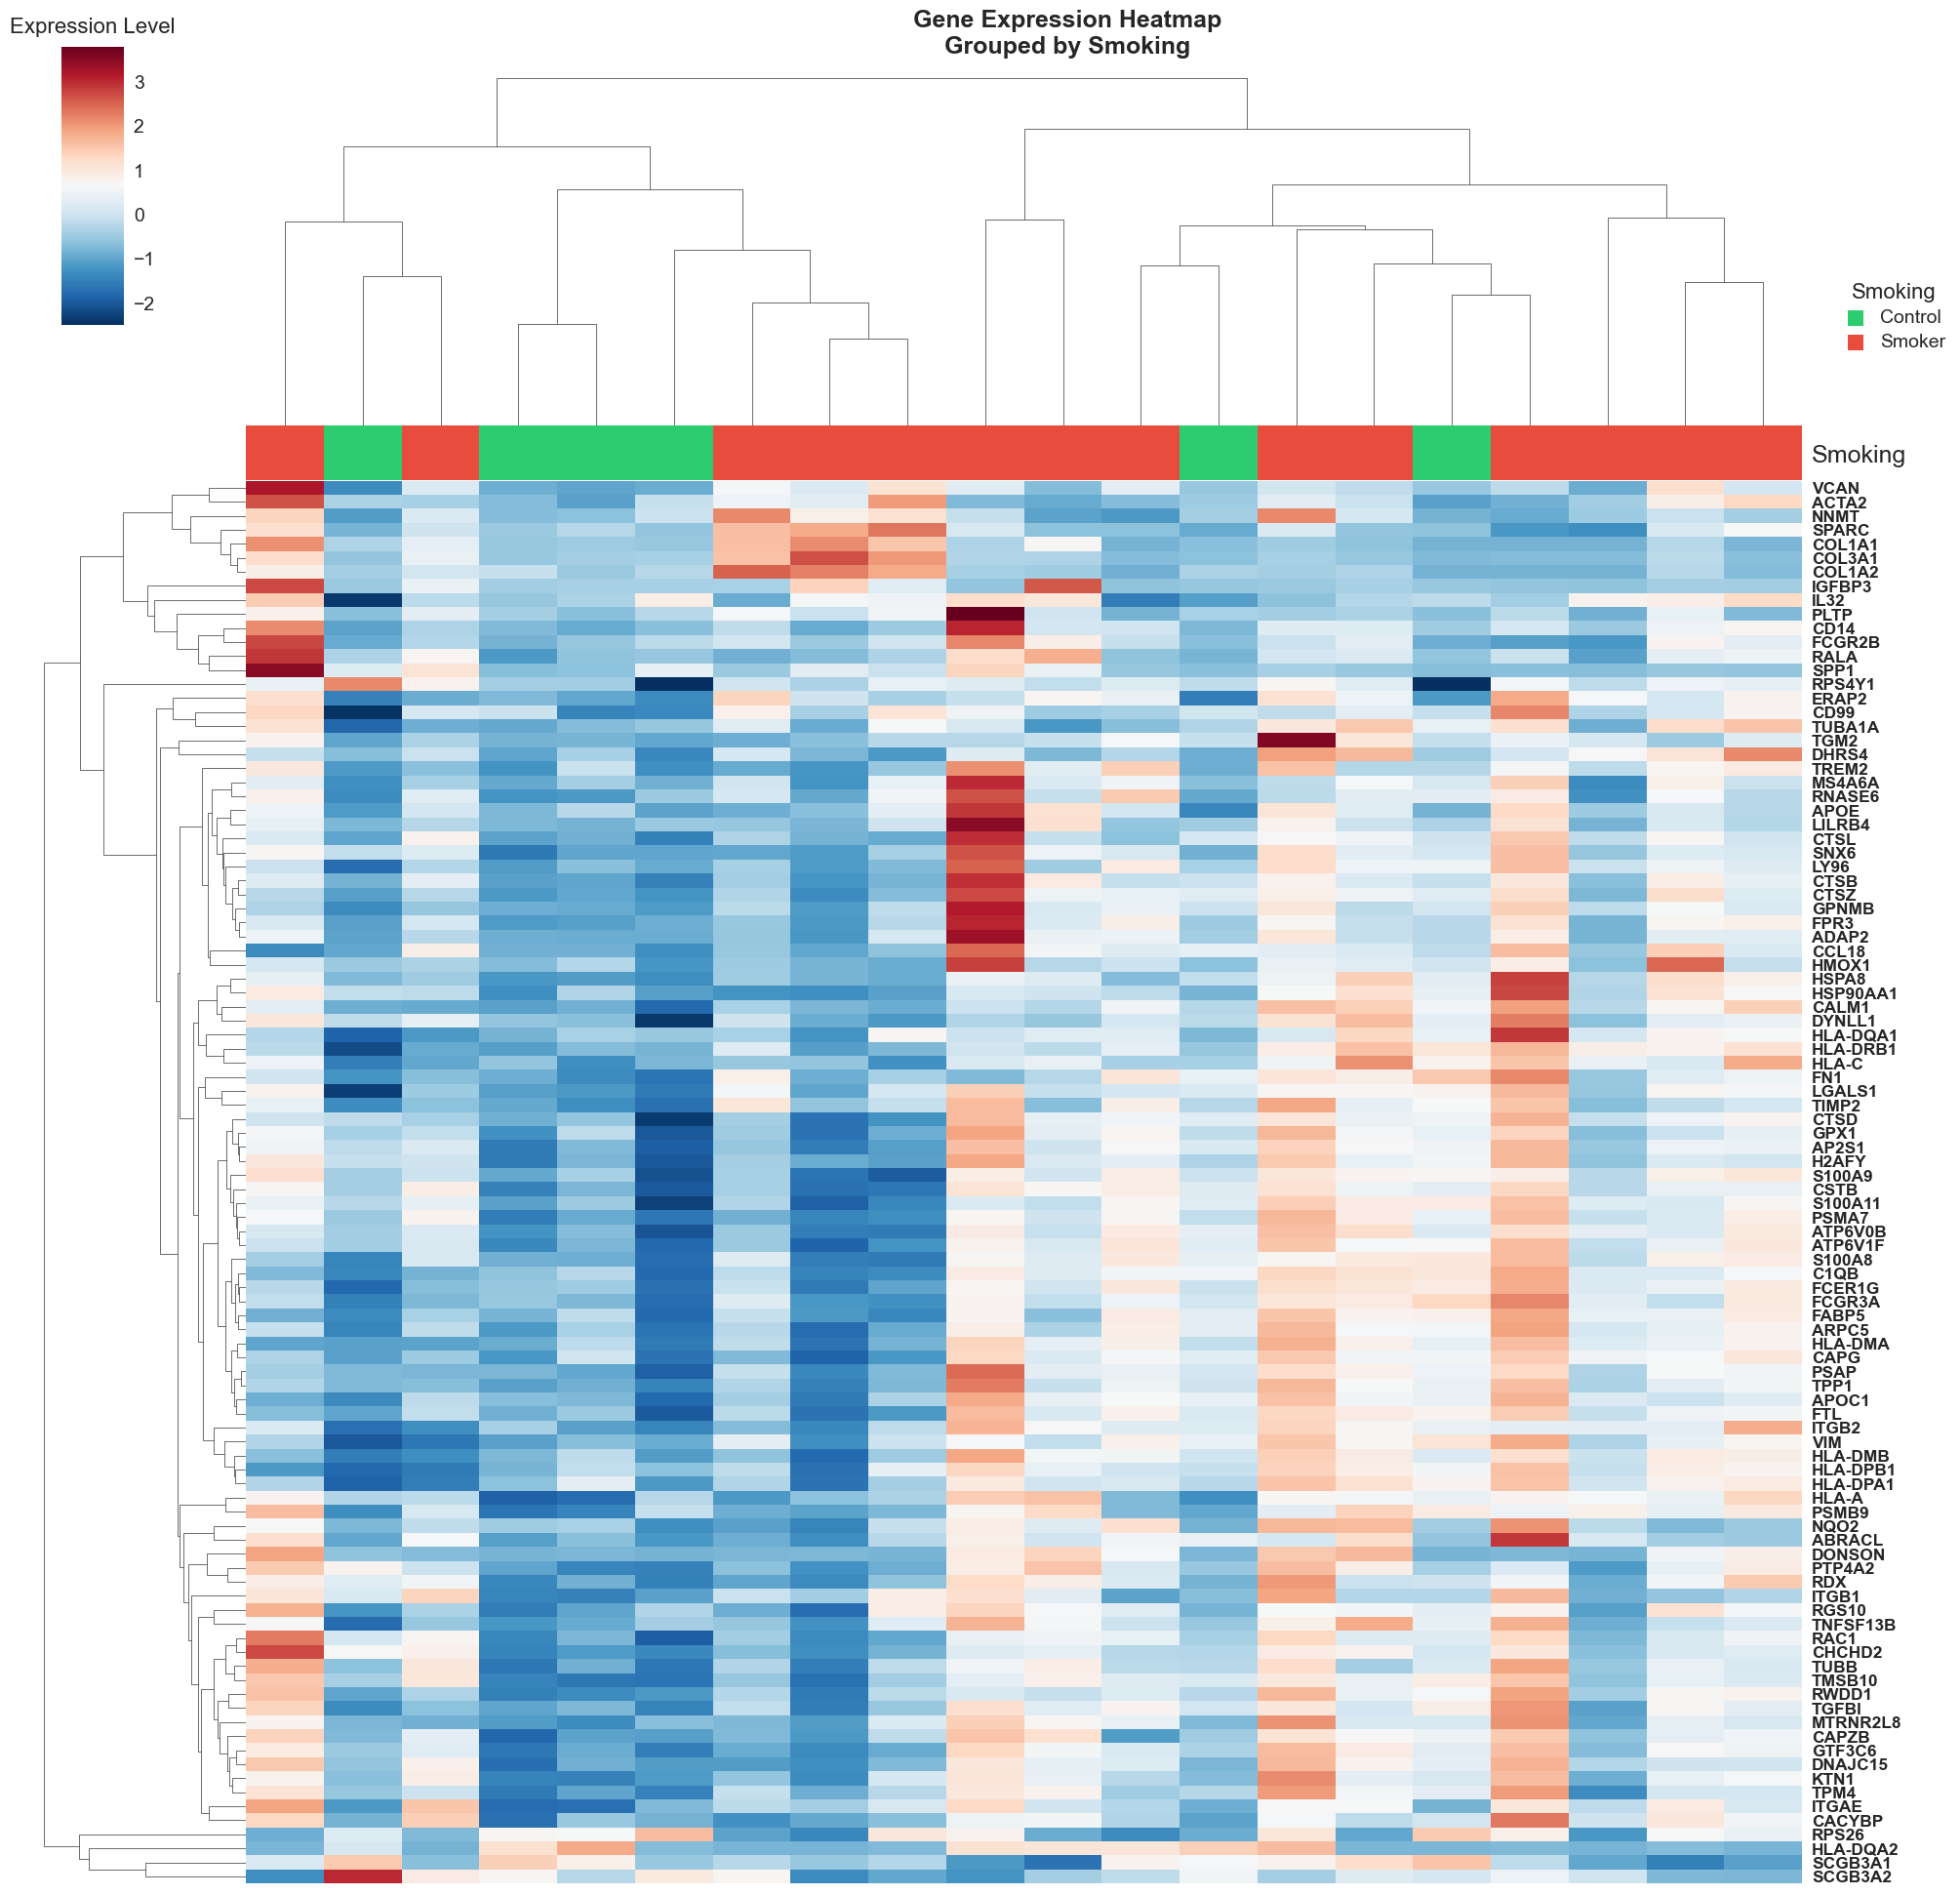

In [77]:
filtered_smoking, smoking_results = get_differential_genes_multi(
    data, 
    'Smoking',
    top_n=100,
    ranking_method='combined'
)


g = gene_expression_heatmap(filtered_smoking, 'Smoking', top_n=100)
plt.savefig('heatmap.png', dpi=600, bbox_inches='tight', pad_inches=0.5)
plt.show()

In [78]:
filtered_dfs, results = get_differential_genes_multi(
    data, 
    ['Tissue_origin', 'Smoking'],
    p_threshold=0.05,
    fc_threshold=1.0
)

/var/folders/dh/ct60f64n7r30w2htbyy2py5c0000gn/T/ipykernel_1304/185516433.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[significant_genes] = scaled_gene_data



Analysis Results for Tissue_origin:
Number of samples: 20
Number of selected genes: 52

Top 5 genes:
   Gene Group1 Group2  Fold_Change  T_test_pvalue  Rank_Score
  FABP4  nLung  tLung    -2.568219       0.000002   14.430467
 MCEMP1  nLung  tLung    -1.805053       0.000002   10.413166
  IGLC2  nLung  tLung     3.336348       0.001235    9.703735
SCGB1A1  nLung  tLung    -2.533597       0.000468    8.437212
   IGKC  nLung  tLung     3.200134       0.002985    8.080609
--------------------------------------------------

Analysis Results for Smoking:
Number of samples: 20
Number of selected genes: 3

Top 5 genes:
   Gene Group1 Group2  Fold_Change  T_test_pvalue  Rank_Score
   APOE  Never Smoker     1.562064       0.000525    5.123707
SCGB3A1  Never Smoker    -1.848811       0.009519    3.737188
  CCL18  Never Smoker     1.295725       0.030868    1.957187
SCGB3A2  Never Smoker    -1.484853       0.051933    1.907375
   CTSB  Never Smoker     0.849592       0.009267    1.727287
--------

/var/folders/dh/ct60f64n7r30w2htbyy2py5c0000gn/T/ipykernel_1304/185516433.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[significant_genes] = scaled_gene_data


In [79]:
results['Tissue_origin'].head(10)

,Gene,Feature,Group1,Group2,nLung_Mean,tLung_Mean,Fold_Change,T_statistic,T_test_pvalue,Cohens_d,nLung_Samples,tLung_Samples,Abs_Fold_Change,Significant,Rank_Score
8080,FABP4,Tissue_origin,nLung,tLung,3.474049,0.905830,-2.568219,6.926508,0.000002,-3.097629,10,10,2.568219,True,14.430467
13541,MCEMP1,Tissue_origin,nLung,tLung,2.345896,0.540844,-1.805053,7.089682,0.000002,-3.170602,10,10,1.805053,True,10.413166
10734,IGLC2,Tissue_origin,nLung,tLung,1.156644,4.492992,3.336348,-3.925716,0.001235,1.755634,10,10,3.336348,True,9.703735
24438,SCGB1A1,Tissue_origin,nLung,tLung,3.896131,1.362534,-2.533597,4.295488,0.000468,-1.921001,10,10,2.533597,True,8.437212
10677,IGKC,Tissue_origin,nLung,tLung,2.484334,5.684468,3.200134,-3.481473,0.002985,1.556962,10,10,3.200134,True,8.080609
13467,MARCO,Tissue_origin,nLung,tLung,2.974710,1.238587,-1.736123,4.865200,0.000126,-2.175784,10,10,1.736123,True,6.773163
8466,FBP1,Tissue_origin,nLung,tLung,2.756529,1.189706,-1.566823,5.240088,0.000056,-2.343439,10,10,1.566823,True,6.661310
10735,IGLC3,Tissue_origin,nLung,tLung,0.980582,3.554248,2.573666,-3.603314,0.002891,1.611451,10,10,2.573666,True,6.534528
14844,NKG7,Tissue_origin,nLung,tLung,2.612128,1.249620,-1.362508,5.720776,0.000028,-2.558409,10,10,1.362508,True,6.201387
1818,ALDH2,Tissue_origin,nLung,tLung,2.490846,1.120467,-1.370380,5.480521,0.000045,-2.450963,10,10,1.370380,True,5.962764


In [80]:
results['Smoking'].head(20)

,Gene,Feature,Group1,Group2,Never_Mean,Smoker_Mean,Fold_Change,T_statistic,T_test_pvalue,Cohens_d,Never_Samples,Smoker_Samples,Abs_Fold_Change,Significant,Rank_Score
2319,APOE,Smoking,Never,Smoker,2.112112,3.674176,1.562064,-4.211596,5.247001e-04,1.738909,6,14,1.562064,True,5.123707
24448,SCGB3A1,Smoking,Never,Smoker,3.855922,2.007112,-1.848811,3.158000,9.519171e-03,-1.507062,6,14,1.848811,True,3.737188
4178,CCL18,Smoking,Never,Smoker,1.562046,2.857771,1.295725,-2.367225,3.086772e-02,1.032667,6,14,1.295725,True,1.957187
24449,SCGB3A2,Smoking,Never,Smoker,3.003585,1.518732,-1.484853,2.346470,5.193329e-02,-1.234426,6,14,1.484853,False,1.907375
6579,CTSB,Smoking,Never,Smoker,1.701189,2.550781,0.849592,-2.951780,9.266645e-03,1.282519,6,14,0.849592,False,1.727287
4261,CD14,Smoking,Never,Smoker,0.439458,0.986515,0.547057,-3.702019,2.149460e-03,1.429760,6,14,0.547057,False,1.459368
10142,HLA-DQA1,Smoking,Never,Smoker,1.855746,2.793480,0.937734,-2.341198,3.542893e-02,1.066257,6,14,0.937734,False,1.360316
2313,APOC1,Smoking,Never,Smoker,3.014566,4.156690,1.142124,-1.980534,7.507280e-02,0.951433,6,14,1.142124,False,1.284338
7886,ERAP2,Smoking,Never,Smoker,0.103373,0.307959,0.204587,-7.340258,8.240429e-07,3.043029,6,14,0.204587,False,1.244716
5154,COL1A1,Smoking,Never,Smoker,0.266082,0.996738,0.730656,-2.590969,2.105013e-02,0.993812,6,14,0.730656,False,1.225123
